[Multi-scale context aggregation by dilated convolutions](https://arxiv.org/abs/1511.07122)

[code no.1](https://github.com/fyu/dilation)
[code no.2](https://github.com/bordesf/dilation)


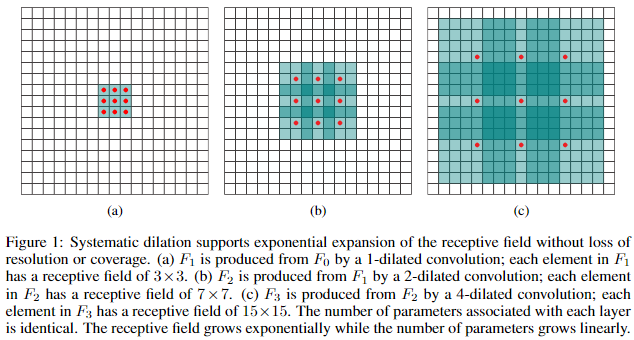

matrix表示为文本的词向量concat的矩阵，纵向为词序列，横向为词向量

通过dilated convolutions，扩大视野域，一定程度上解决序列问题的长程依赖的问题。

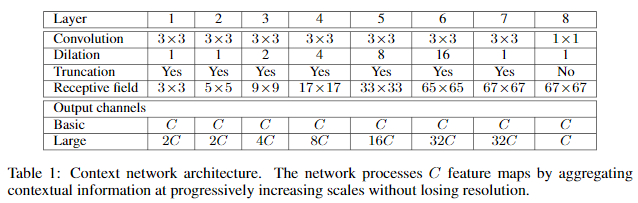

针对语义分割问题 semantic segmentation，这里使用 dilated convolutions 得到multi-scale context 信息来提升分割效果

## Dilated/Atrous Convolution原理

常规卷积, [来源](https://github.com/vdumoulin/conv_arithmetic)
![pic](./pic/standconv.gif)

膨胀卷积
![pic](./pic/dilated.gif)

对于一个卷积层，如果希望增加输出单元的感受野，一般可以通过三种方式实现：

（1）增加卷积核的大小；（2）增加层数；（3）在卷积之前进行汇聚操作。

前两种操作会增加参数数量，而第三种会丢失一些信息。

卷积stack在感受野上的神奇效果

    This (stack of three 3 × 3 conv layers) can be seen as imposing a regularisation on the 7 × 7 conv. filters, forcing them to have a decomposition through the 3 × 3 filters (with non-linearity injected in between).
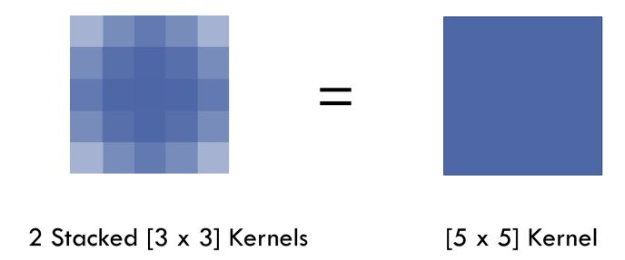

Deep CNN 还有一些致命性的缺陷。较为著名的是 up-sampling 和 pooling layer 的设计。 Hinton 的演讲里也提到过。

- Up-sampling：inserting zero-valued samples between original samples to increase the sampling rate. (This is sometimes called “zero-stuffing”.) 
- pooling layer (e.g. bilinear interpolation) is deterministic. (a.k.a. not learnable)
- 内部数据结构丢失；空间层级化信息丢失
- 小物体信息无法重建 (假设有四个pooling layer 则 任何小于 2^4 = 16 pixel 的物体信息将理论上无法重建)

dilated convolution， 内部数据结构的保留和避免使用 down-sampling 这样的特性。
    
    downsampling即下采样，主要是对数字信号进行下采样操作，例如数字图像处理中对图片进行压缩时，N*N的矩阵变成了(N/2)*(N/2)，这个步骤就是对原图片进行了下采样
    
    upsampling与downsampling概念相反，也可以理解成插值(interpolation)

空洞卷积（atrous convolutions），也称为膨胀卷积（dilated convolution），是一种不增加参数数量，同时增加输出单元感受野的一种方法（atrous一词来源于法语）

空洞卷积通过给卷积核插入“空洞”来变相地增加其大小。如果在卷积核的每两个元素之间插入d−1个空洞，卷积核的有效大小为：

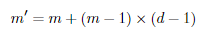

其中d称为膨胀率（dilation rate）。当<span class="mark">d= 1时卷积核为普通的卷积核</span>。

空洞卷积（atrous convolutions），也称为膨胀卷积（dilated convolution），是一种不增加参数数量，同时增加输出单元感受野的一种方法（atrous一词来源于法语）

### 潜在问题
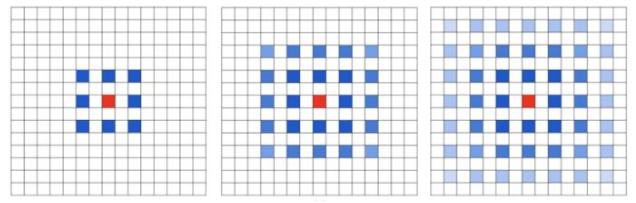
1 仅仅多次叠加 dilation rate 2 的 3 x 3 kernel，kernel 并不连续，也就是并不是所有的 pixel 都用来计算了，因此这里将信息看做 checker-board 的方式会损失信息的连续性。这对 pixel-level dense prediction 的任务来说是致命的。

2 Long-ranged information might be not relevant：采用大 dilation rate 的信息或许只对一些大物体分割有效果，而对小物体来说可能则有弊无利了。

### 优化网络
[文章](https://arxiv.org/abs/1706.05587)

#### 标准化设计：Hybrid Dilated Convolution (HDC)
- 第一个特性是，叠加卷积的 dilation rate 不能有大于1的公约数。比如 [2, 4, 6] 则不是一个好的三层卷积，依然会出现 gridding effect。
- 第二个特性是，我们将 dilation rate 设计成 锯齿状结构，例如 [1, 2, 5, 1, 2, 5] 循环结构。
- 第三个特性是，我们需要满足一下这个式子： 
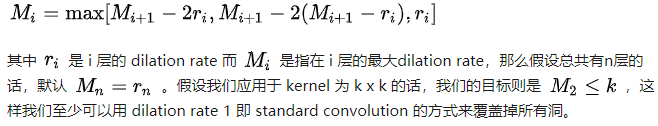

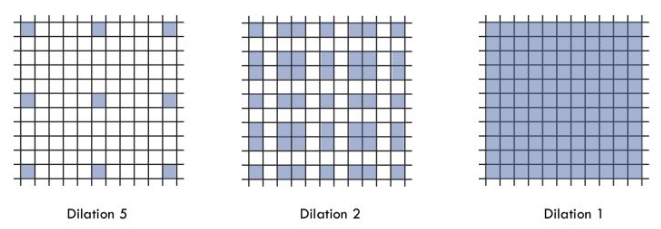

这样的锯齿状本身的性质就比较好的来同时满足小物体大物体的分割要求(小 dilation rate 来关心近距离信息，大 dilation rate 来关心远距离信息)

处理多尺度物体分割时，我们通常会有以下几种方式来操作：
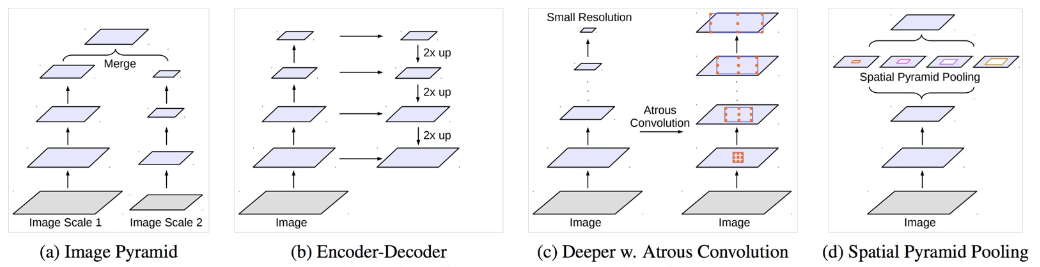

Atrous Spatial Pyramid Pooling (ASPP),将Dilated/Atrous和Spatial Pyramid Pooling结合，在网络 decoder 上对于不同尺度上用<span class="mark">不同大小的 dilation rate</span> 来抓去多尺度信息，每个尺度则为一个独立的分支，在网络最后把他<span class="mark">合并起来再接一个卷积层</span>输出预测 label。

这样的设计则有效避免了在 encoder 上冗余的信息的获取，直接关注与物体之间之内的相关性。


### 其他应用

dilated的好处是不做pooling损失信息的情况下，加大了感受野，让每个卷积输出都包含较大范围的信息。在图像需要全局信息或者语音文本需要较长的sequence信息依赖的问题中，都能很好的应用dilated conv，比如图像分割、语音合成WaveNet、机器翻译ByteNet中。

ByteNet
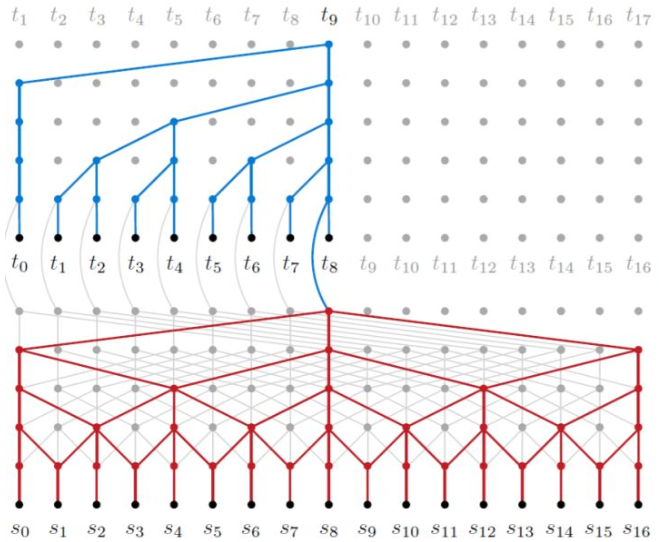

#### deconv和dilated conv的区别：
deconv即是反卷积，deconv的其中一个用途是做upsampling，即增大图像尺寸。而dilated conv并不是做upsampling，而是增大感受野。

可以形象的做个解释：对于标准的k\*k卷积操作，stride为s，分三种情况：  
> (1) s>1，即卷积的同时做了downsampling，卷积后图像尺寸减小；
>
> (2) s=1，普通的步长为1的卷积，比如在tensorflow中设置padding=SAME的话，卷积的图像输入和输出有相同的尺寸大小；
>
> (3) 0<s<1，fractionally strided convolution，相当于对图像做upsampling。比如s=0.5时，意味着在图像每个像素之间padding一个空白的像素后，stride改为1做卷积，得到的feature map尺寸增大一倍。

而dilated conv不是在像素之间padding空白的像素，而是在已有的像素上，skip掉一些像素，或者输入不变，对conv的kernel参数中插一些0的weight，达到一次卷积看到的空间范围变大的目的。

当然将普通的卷积stride步长设为大于1，也会达到增加感受野的效果，但是stride大于1就会导致downsampling，图像尺寸变小。


## 代码

### 训练主要流程和IDCNN(dilated convolutions)核心代码
```python
# embeddings for chinese character and segmentation representation
    ...
    embedding = self.embedding_layer(self.char_inputs, self.seg_inputs, config)

    # apply dropout before feed to idcnn layer
    model_inputs = tf.nn.dropout(embedding, self.dropout)

    # ldcnn layer
    model_outputs = self.IDCNN_layer(model_inputs)

    # logits for tags
    self.logits = self.project_layer_idcnn(model_outputs)

    # loss of the model
    self.loss = self.loss_layer(self.logits, self.lengths)

    self.opt = tf.train.AdamOptimizer(self.lr)

    # apply grad clip to avoid gradient explosion
    grads_vars = self.opt.compute_gradients(self.loss)
    capped_grads_vars = [[tf.clip_by_value(g, -self.config["clip"], self.config["clip"]), v]
                         for g, v in grads_vars]
    self.train_op = self.opt.apply_gradients(capped_grads_vars, self.global_step)
    ...
    
    # IDCNN
    def IDCNN_layer(self, model_inputs, 
                    name=None):
        """IDCNN layer
        :param model_inputs: [batch_size, num_steps, emb_size]
        # emb_size在IDCNN中成了channel数量，这点很重要
        :return: [batch_size, num_steps, cnn_output_width]
        """
        # tf.expand_dims会向tensor中插入一个维度，插入位置就是参数代表的位置（维度从0开始）
        model_inputs = tf.expand_dims(model_inputs, 1)
        self.model_inputs_test=model_inputs
        reuse = False

        if self.dropout == 1.0:
            reuse = True
        with tf.variable_scope("idcnn" if not name else name):
            shape=[1, self.filter_width, self.embedding_dim,
                   self.num_filter]   # [1*3*120*100]
            print(shape)
            filter_weights = tf.get_variable(
                "idcnn_filter",
                shape=shape,
                initializer=self.initializer)

            # shape of input = [batch, in_height, in_width, in_channels]
            # in_height：一句话为1，in_width：seq length，in_channels：embedding dim
            # shape of filter = [filter_height, filter_width, in_channels, out_channels]
            # in_channels：embedding dim，out_channels：number of filters

            layerInput = tf.nn.conv2d(model_inputs,
                                      filter_weights,
                                      strides=[1, 1, 1, 1],
                                      padding="SAME",
                                      name="init_layer",use_cudnn_on_gpu=True)
            self.layerInput_test=layerInput
            finalOutFromLayers = []
            
            totalWidthForLastDim = 0
            for j in range(self.repeat_times):
                for i in range(len(self.layers)):
                    dilation = self.layers[i]['dilation']  # 1,1,2
                    isLast = True if i == (len(self.layers) - 1) else False

                    with tf.variable_scope("atrous-conv-layer-%d" % i,
                                           reuse=True
                                           if (reuse or j > 0) else False):
                        # shape: 卷积核的高度，卷积核的宽度，通道数，卷积核个数
                        w = tf.get_variable(
                            "filterW",
                            shape=[1, self.filter_width, self.num_filter,
                                   self.num_filter],
                            initializer=tf.contrib.layers.xavier_initializer())
                        if j==1 and i==1:
                            self.w_test_1=w
                        if j==2 and i==1:
                            self.w_test_2=w                            
                        b = tf.get_variable("filterB", shape=[self.num_filter])
'''
tf.nn.atrous_conv2d(value,filters,rate,padding,name=None）
    # value： [batch, height, width, channels]这样的shape，
        > [训练时一个batch的sentence数量, sentence高度(1), sentence宽度(length), sentence通道数(embedding dim)]
    # filters：[filter_height, filter_width, channels, out_channels]
        > [卷积核的高度，卷积核的宽度，图像通道数，卷积核个数]
    # rate：int型的正数，空洞卷积默认stride=1，也就是滑动步长无法改变，固定为1
        > rate参数，它定义为我们在输入图像上卷积时的采样间隔，相当于卷积核中穿插了（rate-1）数量的“0”，
        > 这样做卷积时就相当于对原图像的采样间隔变大了。rate=1时，就没有0插入，相当于普通卷积。
    # padding： string，”SAME”,”VALID”其中之一，决定不同边缘填充方式。
        > “VALID”，返回[batch,height-(filter_height + (filter_height - 1) * (rate - 1))+1,
                    width-(filter_width + (filter_width - 1) * (rate - 1))+1,out_channels]的Tensor
        > “SAME”，返回[batch, height, width, out_channels]的Tensor'''
                        conv = tf.nn.atrous_conv2d(layerInput,
                                           w,
                                           rate=dilation,
                                           padding="SAME")
                        self.conv_test = conv
                        conv = tf.nn.bias_add(conv, b)
                        conv = tf.nn.relu(conv)
                        if isLast:  # 计算repeat_times次
                            finalOutFromLayers.append(conv)
                            totalWidthForLastDim += self.num_filter
                        layerInput = conv
            finalOut = tf.concat(axis=3, values=finalOutFromLayers)
            keepProb = 1.0 if reuse else 0.5
            finalOut = tf.nn.dropout(finalOut, keepProb)

            # tf.squeeze
            # 给定张量输入，此操作返回相同类型的张量，并删除所有尺寸为1的尺寸。
            # 如果不想删除所有尺寸1尺寸，可以通过指定axis来删除特定尺寸1尺寸。
            # 't' is a tensor of shape [1, 2, 1, 3, 1, 1]
            # tf.shape(tf.squeeze(t, [2, 4]))  # [1, 2, 3, 1]
            finalOut = tf.squeeze(finalOut, [1])
            finalOut = tf.reshape(finalOut, [-1, totalWidthForLastDim])
            self.cnn_output_width = totalWidthForLastDim
            return finalOut
        ...
```